<a href="https://colab.research.google.com/github/djakesa/AE-VAE-GAN-CelebA/blob/main/VAE_learnable_prior.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#On connecte mon drive au google collab

In [1]:
from google.colab import drive
import os
import shutil

# Démontage s'il est déjà monté
try:
    !fusermount -u /content/drive
except:
    pass

# Suppression du dossier de montage s'il reste
if os.path.exists('/content/drive'):
    shutil.rmtree('/content/drive', ignore_errors=True)

# Montage propre
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


#Importer la BDD via google drive

- J'ai déjà importé des photos de la BDD CelebA pour la suite lorsque j'ai construit mon AE à : /content/drive/MyDrive/img_align_celeba/img_align_celeba

- On va quand même tester si c'est ok avec ce path

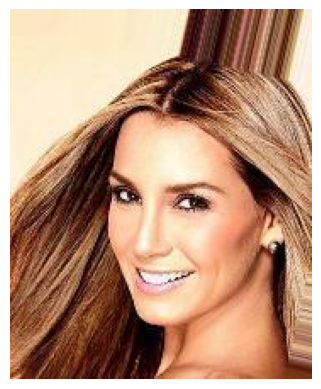

In [2]:
import cv2
import matplotlib.pyplot as plt

img= cv2.imread('/content/drive/MyDrive/img_align_celeba/img_align_celeba/000001.jpg')
img= cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.figure()
plt.imshow(img)
plt.axis('off')
plt.show()

#On va maintenant construire le VAE

In [94]:
from keras.layers import Input, Conv2D, Flatten, Dense, Conv2DTranspose, Reshape, Activation, BatchNormalization, LeakyReLU, Dropout
from keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Layer
from tensorflow.keras.callbacks import Callback, LearningRateScheduler
from tensorflow.keras.models import load_model
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input
import tensorflow as tf
import numpy as np
import os
import json

# Learning rate scheduler
def step_decay_schedule(initial_lr, decay_factor=0.8, step_size=50):
    def schedule(epoch):
        return initial_lr * (decay_factor ** (epoch // step_size))
    return LearningRateScheduler(schedule, verbose=1)

class Sampling(Layer):
    def call(self, inputs):
        mu, log_var = inputs
        epsilon = tf.random.normal(shape=tf.shape(mu), mean=0.0, stddev=1.0)
        z = mu + tf.exp(0.5 * log_var) * epsilon

        kl_loss = -0.5 * tf.reduce_sum(1 + log_var - tf.square(mu) - tf.exp(log_var), axis=1)
        kl_mean = tf.reduce_mean(kl_loss)
        self.add_loss(80*kl_mean)
        return z

class Decodeur_learnable(Layer):
    def __init__(self, **kwargs):
        super(Decodeur_learnable, self).__init__(**kwargs)
        self.log_var = self.add_weight(
            name='log_var',
            shape=(1,),
            initializer='zeros',
            trainable=True
        )

    def call(self, inputs):
        y_true, y_pred = inputs
        var = tf.clip_by_value(tf.exp(self.log_var), 1e-3, 100.0)
        n = tf.cast(tf.reduce_prod(tf.shape(y_true)[1:]), tf.float32)
        mse = tf.reduce_sum(tf.square(y_true - y_pred), axis=[1, 2, 3])

        log_likelihood = - (n / 2) * tf.math.log(2 * np.pi) - (n / 2) * tf.math.log(var) - mse / (2 * var)
        neg_log_likelihood = -tf.reduce_mean(log_likelihood)
        self.add_loss(neg_log_likelihood)
        return y_pred

class FeatureLossVGG(Layer):
    def __init__(self, **kwargs):
        super(FeatureLossVGG, self).__init__(**kwargs)
        vgg = VGG19(include_top=False, weights='imagenet', input_shape=(128, 128, 3))
        vgg.trainable = False
        selected_layers = ['block1_conv2', 'block2_conv1', 'block3_conv1']
        self.vgg_model = Model(inputs=vgg.input, outputs=[vgg.get_layer(name).output for name in selected_layers])

    def call(self, inputs):
        y_true, y_pred = inputs
        y_true_pp = preprocess_input(y_true * 255.0)
        y_pred_pp = preprocess_input(y_pred * 255.0)
        f_true = self.vgg_model(y_true_pp)
        f_pred = self.vgg_model(y_pred_pp)

        loss = 0.0
        for ft, fp in zip(f_true, f_pred):
            loss += tf.reduce_mean(tf.square(ft - fp))

        self.add_loss(0.5*loss)
        return y_pred

class VAE():
    def __init__(self, input_dim, encoder_conv_filters, encoder_conv_kernel_size,
                 encoder_conv_strides, decoder_conv_t_filters, decoder_conv_t_kernel_size,
                 decoder_conv_t_strides, z_dim, use_batch_norm=False, use_dropout=True):

        self.name = 'variational_autoencoder'
        self.input_dim = input_dim
        self.encoder_conv_filters = encoder_conv_filters
        self.encoder_conv_kernel_size = encoder_conv_kernel_size
        self.encoder_conv_strides = encoder_conv_strides
        self.decoder_conv_t_filters = decoder_conv_t_filters
        self.decoder_conv_t_kernel_size = decoder_conv_t_kernel_size
        self.decoder_conv_t_strides = decoder_conv_t_strides
        self.z_dim = z_dim
        self.use_batch_norm = use_batch_norm
        self.use_dropout = use_dropout
        self.n_layers_encoder = len(encoder_conv_filters)
        self.n_layers_decoder = len(decoder_conv_t_filters)

        self._build()

    def _build(self):
        encoder_input = Input(shape=self.input_dim, name="encoder_input_layer")
        y_true_input = Input(shape=self.input_dim, name="reconstruction_target")
        x = encoder_input

        for i in range(self.n_layers_encoder):
            x = Conv2D(filters=self.encoder_conv_filters[i],
                       kernel_size=self.encoder_conv_kernel_size[i],
                       strides=self.encoder_conv_strides[i],
                       padding='same',
                       name=f'encoder_conv_{i}')(x)
            if self.use_batch_norm:
                x = BatchNormalization()(x)
            x = LeakyReLU()(x)
            if self.use_dropout:
                x = Dropout(0.1)(x)

        self.shape_before_flattening = K.int_shape(x)[1:]
        x = Flatten()(x)
        mu = Dense(self.z_dim, name='mu')(x)
        log_var = Dense(self.z_dim, name='log_var')(x)
        z = Sampling(name='encoder_output')([mu, log_var])

        self.encoder = Model(encoder_input, z)

        decoder_input = Input(shape=(self.z_dim,), name='decoder_input')
        x = Dense(np.prod(self.shape_before_flattening))(decoder_input)
        x = Reshape(self.shape_before_flattening)(x)

        for i in range(self.n_layers_decoder):
            x = Conv2DTranspose(filters=self.decoder_conv_t_filters[i],
                                kernel_size=self.decoder_conv_t_kernel_size[i],
                                strides=self.decoder_conv_t_strides[i],
                                padding='same',
                                name=f'decoder_conv_t_{i}')(x)
            if i < self.n_layers_decoder - 1:
                if self.use_batch_norm:
                    x = BatchNormalization()(x)
                x = LeakyReLU()(x)
                if self.use_dropout:
                    x = Dropout(0.1)(x)
            else:
                x = Activation('sigmoid')(x)

        self.decoder = Model(decoder_input, x)
        x_hat = self.decoder(self.encoder(encoder_input))

        decoded = Decodeur_learnable(name="log_likelihood_loss")([y_true_input, x_hat])
        final_output = FeatureLossVGG(name="vgg_feature_loss")([y_true_input, decoded])

        self.model = Model(inputs=[encoder_input, y_true_input], outputs=final_output)

    def compile(self, learning_rate):
        self.learning_rate = learning_rate
        optimizer = Adam(learning_rate=self.learning_rate)
        self.model.compile(optimizer=optimizer)

    def train(self, x_train, batch_size, epochs, initial_epoch=0, callbacks=None, lr_decay=0.8):
        lr_sched = step_decay_schedule(initial_lr=self.learning_rate, decay_factor=lr_decay, step_size=20)
        if callbacks is None:
            callbacks = []
        callbacks.append(lr_sched)

        dataset = tf.data.Dataset.from_tensor_slices(((x_train, x_train), None))
        dataset = dataset.shuffle(buffer_size=10000).batch(batch_size).prefetch(tf.data.AUTOTUNE)

        history = self.model.fit(
            dataset,
            shuffle=True,
            epochs=epochs,
            initial_epoch=initial_epoch,
            callbacks=callbacks
        )
        return history

    def save(self, path):
        os.makedirs(path, exist_ok=True)
        self.model.save(os.path.join(path, "vae_model.keras"), include_optimizer=False)
        self.encoder.save(os.path.join(path, "encoder_model.keras"), include_optimizer=False)
        self.decoder.save(os.path.join(path, "decoder_model.keras"), include_optimizer=False)
        config = {
            "input_dim": self.input_dim,
            "encoder_conv_filters": self.encoder_conv_filters,
            "encoder_conv_kernel_size": self.encoder_conv_kernel_size,
            "encoder_conv_strides": self.encoder_conv_strides,
            "decoder_conv_t_filters": self.decoder_conv_t_filters,
            "decoder_conv_t_kernel_size": self.decoder_conv_t_kernel_size,
            "decoder_conv_t_strides": self.decoder_conv_t_strides,
            "z_dim": self.z_dim,
            "use_batch_norm": self.use_batch_norm,
            "use_dropout": self.use_dropout
        }
        with open(os.path.join(path, "config.json"), "w") as f:
            json.dump(config, f)

    @classmethod
    def load(cls, path):
        with open(os.path.join(path, "config.json"), "r") as f:
            config = json.load(f)
        vae = cls(**config)
        custom_objects = {
            "Sampling": Sampling,
            "Decodeur_learnable": Decodeur_learnable,
            "FeatureLossVGG": FeatureLossVGG
        }
        vae.model = load_model(os.path.join(path, "vae_model.keras"), custom_objects=custom_objects, compile=False)
        vae.encoder = load_model(os.path.join(path, "encoder_model.keras"), custom_objects=custom_objects, compile=False)
        vae.decoder = load_model(os.path.join(path, "decoder_model.keras"), compile=False)
        return vae


In [4]:
# Chargement de 1000 images CelebA depuis le dossier extrait
import cv2
import numpy as np
import os

image_dir = '/content/drive/MyDrive/img_align_celeba/img_align_celeba'
image_paths = sorted([
    os.path.join(image_dir, fname)
    for fname in os.listdir(image_dir)
    if fname.endswith('.jpg')
])[:1000]  # pour un entraînement rapide

def load_images(paths):
    images = []
    for path in paths:
        img = cv2.imread(path)
        # Check if image was loaded correctly
        if img is None:
            print(f"Error loading image: {path}")
            continue  # Skip this image and proceed with the next
        img = cv2.resize(img, (128, 128))  # <<< réduction de taille ici
        img = img.astype('float32') / 255.0
        images.append(img)
    # Check if any images were loaded
    if not images:  # If images list is empty
        raise ValueError("No images were loaded. Check image paths and formats.")
    return np.array(images)

x_train = load_images(image_paths)

Error loading image: /content/drive/MyDrive/img_align_celeba/img_align_celeba/000165.jpg


In [95]:
vae = VAE(
    input_dim=(128, 128, 3),

    encoder_conv_filters=[32, 64, 128, 256],
    encoder_conv_kernel_size=[3]*4,
    encoder_conv_strides=[2, 2, 2, 2],

    decoder_conv_t_filters=[256, 128, 64, 32, 3],
    decoder_conv_t_kernel_size=[3]*5,
    decoder_conv_t_strides=[2, 2, 2, 2, 1],

    z_dim=200,

    use_batch_norm=True,
    use_dropout=True
)


In [96]:
vae.encoder.summary()
vae.decoder.summary()
vae.model.summary()

Model: "functional_31"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_input_layer │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_conv_0      │ (None, 64, 64,    │        896 │ encoder_input_la… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        128 │ encoder_conv_0[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_64      │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_64          │ (None, 64, 64,    │          0 │ leaky_re_lu_64[0… │
│ (Dropout)           │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_conv_1      │ (None, 32, 32,    │     18,496 │ dropout_64[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ encoder_conv_1[0… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_65      │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_65          │ (None, 32, 32,    │          0 │ leaky_re_lu_65[0… │
│ (Dropout)           │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_conv_2      │ (None, 16, 16,    │     73,856 │ dropout_65[0][0]  │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │        512 │ encoder_conv_2[0… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_66      │ (None, 16, 16,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_66          │ (None, 16, 16,    │          0 │ leaky_re_lu_66[0… │
│ (Dropout)           │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_conv_3      │ (None, 8, 8, 256) │    295,168 │ dropout_66[0][0]  │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8, 8, 256) │      1,024 │ encoder_conv_3[0… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_67      │ (None, 8, 8, 256) │          0 │ batch_normalizat… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_67          │ (None, 8, 8, 256) │          0 │ leaky_re_lu_67[0

 Total params: 6,944,336 (26.49 MB)

 Trainable params: 6,943,376 (26.49 MB)

 Non-trainable params: 960 (3.75 KB)

Model: "functional_32"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ decoder_input (InputLayer)      │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 16384)          │     3,293,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_8 (Reshape)             │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_conv_t_0                │ (None, 16, 16, 256)    │       590,080 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_68          │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_68 (LeakyReLU)      │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_68 (Dropout)            │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_conv_t_1                │ (None, 32, 32, 128)    │       295,040 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_69          │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_69 (LeakyReLU)      │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_69 (Dropout)            │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_conv_t_2                │ (None, 64, 64, 64)     │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_70          │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_70 (LeakyReLU)      │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_70 (Dropout)            │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_conv_t_3                │ (None, 128, 128, 32)   │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_71          │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_71 (LeakyReLU)      │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_71 (Dropout)            │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_conv_t_4                │ (None, 128, 128, 3)    │           867 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 4,273,347 (16.30 MB)

 Trainable params: 4,272,387 (16.30 MB)

 Non-trainable params: 960 (3.75 KB)

Model: "functional_34"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_input_layer │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_31       │ (None, 200)       │  6,944,336 │ encoder_input_la… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reconstruction_tar… │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_32       │ (None, 128, 128,  │  4,273,347 │ functional_31[0]… │
│ (Functional)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ log_likelihood_loss │ (None, 128, 128,  │          1 │ reconstruction_t… │
│ (Decodeur_learnabl… │ 3)                │            │ functional_32[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vgg_feature_loss    │ (None, 128, 128,  │    555,328 │ reconstruction_t… │
│ (FeatureLossVGG)    │ 3)                │            │ log_likelihood_l… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 11,773,012 (44.91 MB)

 Trainable params: 11,215,764 (42.78 MB)

 Non-trainable params: 557,248 (2.13 MB)

In [97]:
vae.compile(learning_rate=0.001)


Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 31s 917ms/step - loss: 184252.5312 - learning_rate: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.001.
Epoch 2/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 227ms/step - loss: 133336.2656 - learning_rate: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.001.
Epoch 3/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 230ms/step - loss: 127237.5781 - learning_rate: 0.0010

Epoch 4: LearningRateScheduler setting learning rate to 0.001.
Epoch 4/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 232ms/step - loss: 125006.9453 - learning_rate: 0.0010

Epoch 5: LearningRateScheduler setting learning rate to 0.001.
Epoch 5/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 234ms/step - loss: 122689.0469 - learning_rate: 0.0010

Epoch 6: LearningRateScheduler setting learning rate to 0.001.
Epoch 6/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 235ms/step - loss: 119983.8984 - learning_rate: 0.0010

Epoch 7: LearningRateScheduler s

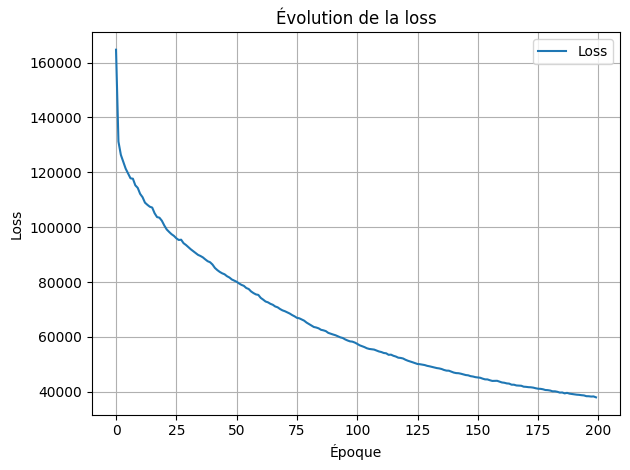

In [98]:
MODE = "build"  # "build" ou "load"
MODEL_DIR = "/content/drive/MyDrive/vae_celeba"

# === Entraînement ou chargement ===
if MODE == "build":

    history = vae.train(
        x_train=x_train,
        batch_size=64,
        epochs=200,
        initial_epoch=0,
        lr_decay=0.85
    )
    os.makedirs(MODEL_DIR, exist_ok=True)
    vae.save(MODEL_DIR)

elif MODE == "load":
    vae = VAE.load(MODEL_DIR)
    history = None

# === Tracé de la loss classique si entraînement effectué ===
if history is not None:
    plt.plot(history.history['loss'], label='Loss')
    plt.xlabel('Époque')
    plt.ylabel('Loss')
    plt.title('Évolution de la loss')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()




# Test pour vérifier le surentrainement




In [9]:
image_dir_test = '/content/drive/MyDrive/img_align_celeba/img_align_celeba'

image_paths_test = sorted([
    os.path.join(image_dir_test, fname)
    for fname in os.listdir(image_dir_test)
    if fname.endswith('.jpg')
])[1001:2000]  # on garde une portion pour un test rapide

def load_images_test(paths_test):
    images = []
    for path_test in paths_test:
        img = cv2.imread(path_test)
        if img is None:
            print(f"Error loading image: {path_test}")
            continue
        img = cv2.resize(img, (128, 128))
        img = img.astype('float32') / 255.0
        images.append(img)
    if not images:
        raise ValueError("No images were loaded.")
    return np.array(images)

x_test = load_images_test(image_paths_test)


In [99]:
vae.model.evaluate([x_test, x_test], x_test)
#The model expects two inputs: the original image and the target (which is the same image in this case)

32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 103ms/step - loss: 62786.7305


62720.71484375

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


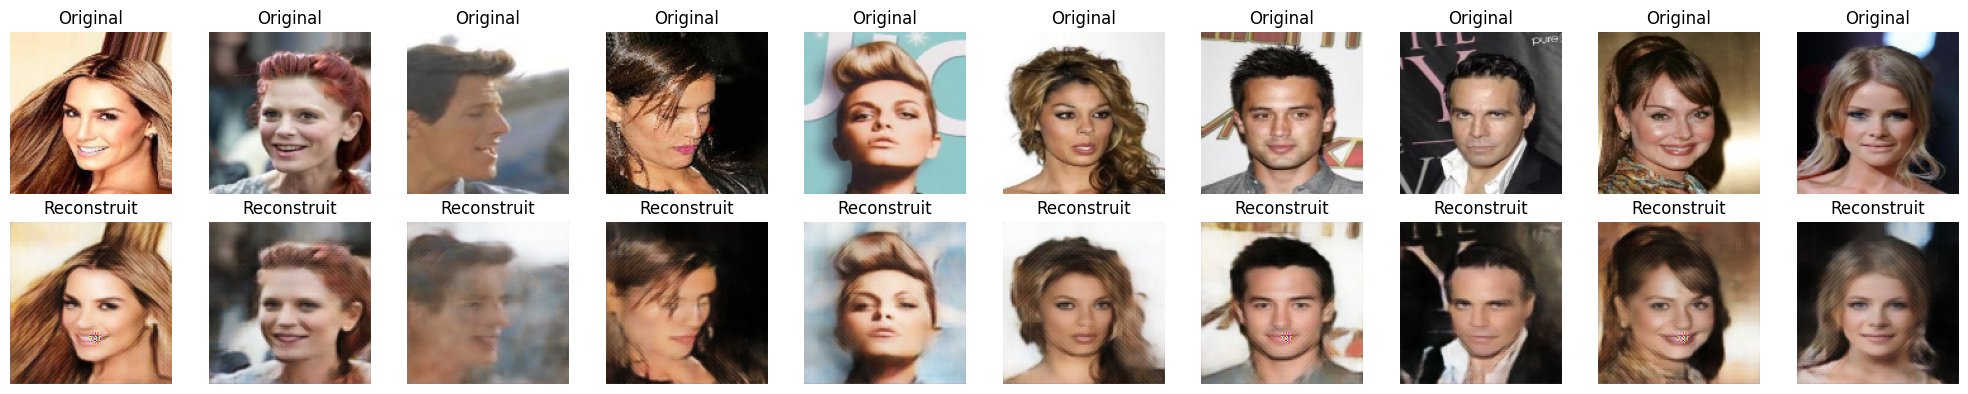

In [100]:
import matplotlib.pyplot as plt
import numpy as np

# Nombre d'images à afficher
n = 10

# Préparer les images originales
test_imgs = x_train[:n]
test_imgs_input = np.copy(test_imgs)

# Reconstruire avec le modèle
reconstructed_imgs = vae.model.predict([test_imgs_input, test_imgs_input])

# Affichage
plt.figure(figsize=(20, 4))

for i in range(n):
    # Ligne 1 : images originales
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(test_imgs[i][..., ::-1])  # BGR → RGB
    plt.axis("off")
    ax.set_title("Original")

    # Ligne 2 : reconstructions
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(reconstructed_imgs[i][..., ::-1])  # BGR → RGB
    plt.axis("off")
    ax.set_title("Reconstruit")

plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


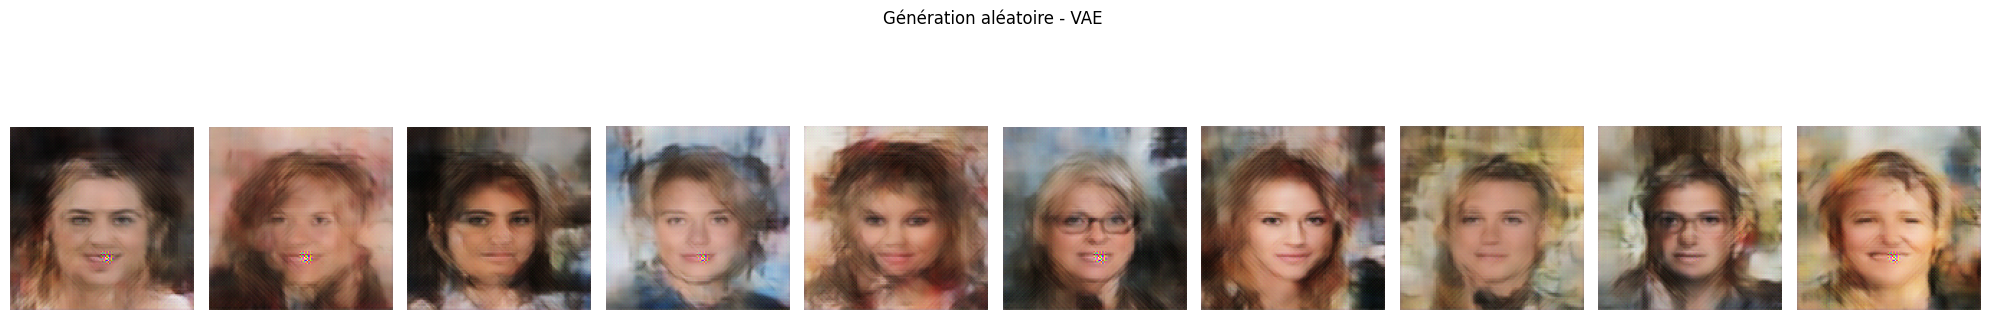

In [119]:
import numpy as np
import matplotlib.pyplot as plt

# Génération de 10 points aléatoires dans l’espace latent
z_samples = np.random.normal(size=(10, vae.z_dim))

# Décodage en images
generated_imgs = vae.decoder.predict(z_samples)

# Affichage
plt.figure(figsize=(20, 4))
for i, img in enumerate(generated_imgs):
    plt.subplot(1, 10, i + 1)
    plt.imshow(img[..., ::-1])  # Les images sont déjà en RGB
    plt.axis('off')

plt.suptitle("Génération aléatoire - VAE ")
plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


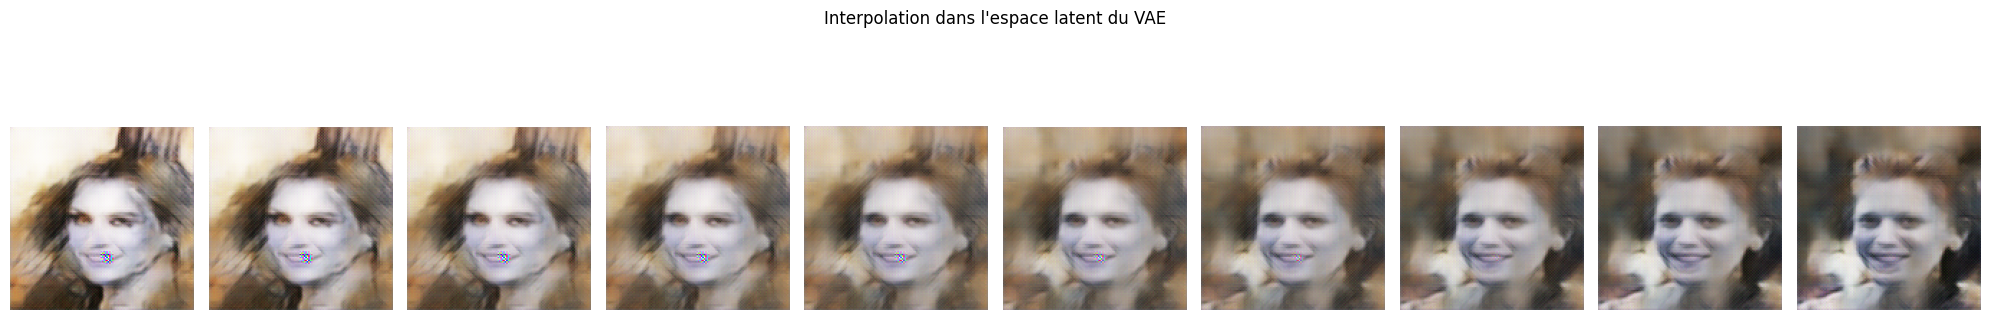

In [116]:
import numpy as np
import matplotlib.pyplot as plt

# Sélection de deux images du dataset
z_start = vae.encoder.predict(x_train[0:1])
z_end = vae.encoder.predict(x_train[1:2])

# Interpolation linéaire entre les deux vecteurs latents
steps = 10
interpolations = np.linspace(z_start, z_end, steps)

# Reshape the interpolations to remove the extra dimension
interpolations_reshaped = interpolations.reshape((steps, vae.z_dim))

# Reconstruction à partir des vecteurs interpolés
reconstructed = vae.decoder.predict(interpolations_reshaped)

# Affichage des images reconstruites
plt.figure(figsize=(20, 4))
for i, img in enumerate(reconstructed):
    plt.subplot(1, steps, i + 1)
    plt.imshow(img)  # Les images sont en RGB
    plt.axis('off')

plt.suptitle("Interpolation dans l'espace latent du VAE")
plt.tight_layout()
plt.show()

Erreur lors du chargement de /content/drive/MyDrive/img_align_celeba/img_align_celeba/000349.jpg
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


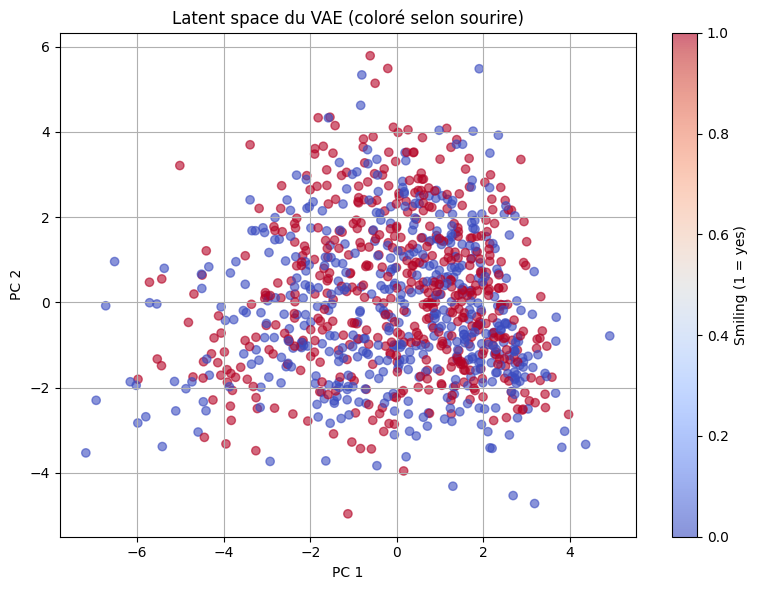

In [121]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pandas as pd
import os
import cv2
import numpy as np

# === Paramètres ===
IMAGE_DIR = "/content/drive/MyDrive/img_align_celeba/img_align_celeba"
IMAGE_SIZE = (128, 128)
ATTR_FILE = "/content/drive/MyDrive/CelebA/Anno/list_attr_celeba.txt"

# === Chargement des attributs (Smiling) ===
attributes_df = pd.read_csv(ATTR_FILE, sep="\s+", skiprows=1)

# === Préparation des chemins d'images ===
image_info = []
for i, fname in enumerate(os.listdir(IMAGE_DIR)):
    if fname.endswith('.jpg'):
        image_info.append((os.path.join(IMAGE_DIR, fname), fname, i))

image_info.sort(key=lambda x: x[1])
image_paths_full = [info[0] for info in image_info][:1000]
image_filenames_full = [info[1] for info in image_info][:1000]

# === Chargement des images ===
def load_images_with_indices(paths):
    images = []
    successful_indices = []
    for i, path in enumerate(paths):
        img = cv2.imread(path)
        if img is None:
            print(f"Erreur lors du chargement de {path}")
            continue
        img = cv2.resize(img, IMAGE_SIZE)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR → RGB
        img = img.astype('float32') / 255.0
        images.append(img)
        successful_indices.append(i)
    return np.array(images), successful_indices

x_train, successful_indices = load_images_with_indices(image_paths_full)
image_filenames_loaded = [image_filenames_full[i] for i in successful_indices]

# === Chargement des labels de sourire ===
smile_labels = attributes_df.loc[image_filenames_loaded, 'Smiling'].values
smile_labels = (smile_labels > 0).astype(int)

# === Encodage des images ===
z_points = vae.encoder.predict(x_train)

# === PCA ===
z_pca = PCA(n_components=2).fit_transform(z_points)

# === Affichage ===
plt.figure(figsize=(8, 6))
plt.scatter(z_pca[:, 0], z_pca[:, 1], c=smile_labels, cmap='coolwarm', alpha=0.6)
plt.colorbar(label='Smiling (1 = yes)')
plt.title('Latent space du VAE (coloré selon sourire)')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.grid(True)
plt.tight_layout()
plt.show()
